<a href="https://colab.research.google.com/github/ezzaa44/Microscopy-Assistant/blob/main/Cell_Image_AI_(Microscopy_Assistant).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install  csbdeep

In [1]:
!pip install cellpose stardist csbdeep tifffile
!pip install opencv-python-headless
!pip install matplotlib pandas openpyxl


In [2]:
from google.colab import files
files.upload()   # upload kaggle.json here


Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"izzahfatimah","key":"808e684bc4f2592153ad047164230332"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d "user164919/brightfield-vs-fluorescent-staining-dataset"
!unzip *.zip -d dataset


Dataset URL: https://www.kaggle.com/datasets/user164919/brightfield-vs-fluorescent-staining-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
brightfield-vs-fluorescent-staining-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  brightfield-vs-fluorescent-staining-dataset.zip
replace dataset/Set_1_Cam_AO_PI_19_02_16/1.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset/Set_1_Cam_AO_PI_19_02_16/1.0.jpg  
  inflating: dataset/Set_1_Cam_AO_PI_19_02_16/1.1.jpg  
  inflating: dataset/Set_1_Cam_AO_PI_19_02_16/1.2.jpg  
  inflating: dataset/Set_1_Cam_AO_PI_19_02_16/10.0.jpg  
  inflating: dataset/Set_1_Cam_AO_PI_19_02_16/10.1.jpg  
  inflating: dataset/Set_1_Cam_AO_PI_19_02_16/10.2.jpg  
  inflating: dataset/Set_1_Cam_AO_PI_19_02_16/11.0.jpg  
  inflating: dataset/Set_1_Cam_AO_PI_19_02_16/11.1.jpg  
  inflating: dataset/Set_1_Cam_AO_PI_19_02_16/11.2.jpg  
  inflating: dataset/Set_1_Cam_AO_PI_19_02_16/12.0.jpg  


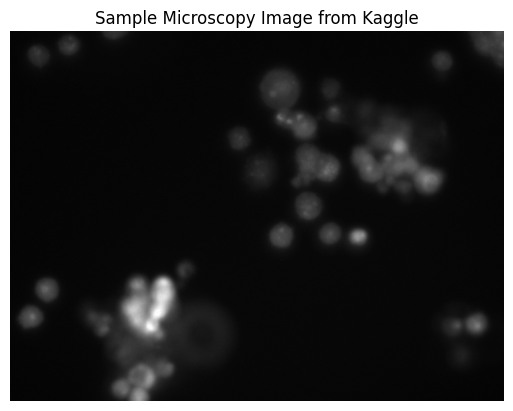

In [5]:
import cv2
import matplotlib.pyplot as plt
import os

# Example: show one image from dataset
image_path = "/content/dataset/Set_1_Cam_AO_PI_19_02_16/10.1.jpg"  # update with actual filename
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

plt.imshow(image, cmap="gray")
plt.title("Sample Microscopy Image from Kaggle")
plt.axis("off")
plt.show()


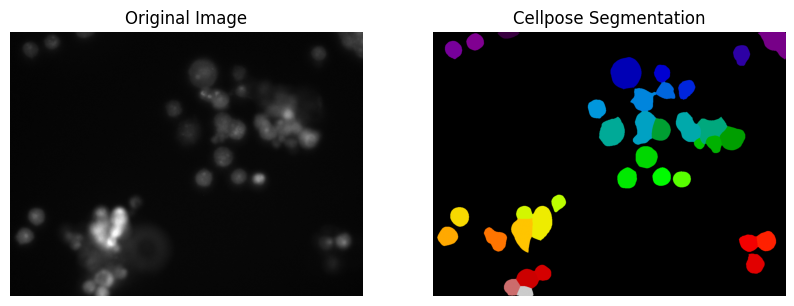

In [6]:
from cellpose import models, io, plot
import matplotlib.pyplot as plt

# Load pretrained Cellpose model (general 'cyto' model works well)
model = models.Cellpose(gpu=False, model_type='cyto')

# Run segmentation on your image
masks, flows, styles, diams = model.eval(image, diameter=None, channels=[0,0])

# Visualize results
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(masks, cmap='nipy_spectral')
plt.title("Cellpose Segmentation")
plt.axis("off")

plt.show()


In [11]:
!pip install  csbdeep

In [12]:
import numpy as np
from skimage.measure import regionprops, label
import pandas as pd

# Label connected components (each cell = unique ID)
labeled_mask = label(masks)

# Extract region properties
props = regionprops(labeled_mask, intensity_image=image)

# Collect metrics in a list of dicts
metrics = []
for p in props:
    metrics.append({
        "Cell_ID": p.label,
        "Area": p.area,
        "Perimeter": p.perimeter,
        "Eccentricity": p.eccentricity,
        "Mean_Intensity": p.mean_intensity
    })

# Convert to DataFrame
df = pd.DataFrame(metrics)

# Show first few rows
print(df.head())

# Save as CSV
df.to_csv("cell_metrics.csv", index=False)


   Cell_ID    Area   Perimeter  Eccentricity  Mean_Intensity
0        1  1659.0  193.639610      0.946427       24.152502
1        2  7337.0  385.001046      0.756182       32.309254
2        3  3539.0  221.036580      0.281232       24.560045
3        4  3627.0  224.450793      0.424450       22.589744
4        5  4018.0  243.379726      0.626201       22.653808


## Batch Processing

In [16]:
import os
import glob
import pandas as pd
from skimage.measure import regionprops, label
import cv2
from cellpose import models

# Root dataset folder containing multiple subfolders
dataset_root = "/content/dataset/Sample"  # update to your dataset root

# Recursively find all images in all subfolders
image_paths = glob.glob(os.path.join(dataset_root, "**", "*.jpg"), recursive=True) + \
              glob.glob(os.path.join(dataset_root, "**", "*.png"), recursive=True) + \
              glob.glob(os.path.join(dataset_root, "**", "*.tif"), recursive=True)

print(f"Found {len(image_paths)} images in all subfolders.")

# Load Cellpose model
model = models.Cellpose(gpu=True, model_type='cyto')

# List to store metrics for all images
all_metrics = []

# Loop through each image
for img_path in image_paths:
    # Load image in grayscale
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Run Cellpose segmentation
    masks, flows, styles, diams = model.eval([image], diameter=None, channels=[0,0])
    mask_single = masks[0]

    # Label cells
    labeled_mask = label(mask_single)

    # Extract metrics
    props = regionprops(labeled_mask, intensity_image=image)
    for p in props:
        all_metrics.append({
            "Folder": os.path.basename(os.path.dirname(img_path)),  # name of parent folder
            "Image": os.path.basename(img_path),
            "Cell_ID": p.label,
            "Area": p.area,
            "Perimeter": p.perimeter,
            "Eccentricity": p.eccentricity,
            "Mean_Intensity": p.mean_intensity
        })

# Convert to DataFrame
df_all = pd.DataFrame(all_metrics)

# Save CSV
df_all.to_csv("all_cells_metrics.csv", index=False)
print("Saved all metrics to all_cells_metrics.csv")


Found 6 images in all subfolders.
Saved all metrics to all_cells_metrics.csv
